# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [441]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd


# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [442]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f



In [443]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f




Exemples d'usage :

In [444]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(1.0, 0.0) # array([1., 2.])
#g = autograd.grad
#print(g(f,0)(0.0,0.0))

array([0.54030231, 2.        ])

In [445]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [446]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [447]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

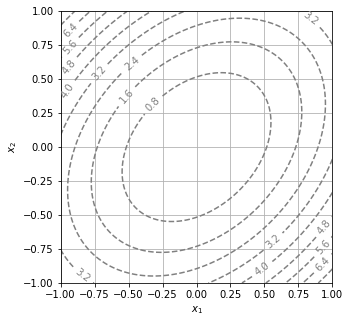

In [448]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [449]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

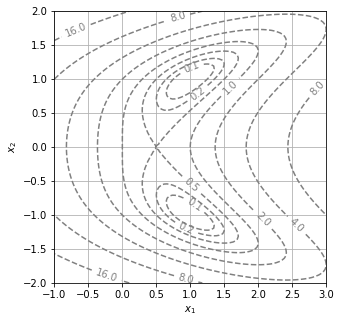

In [450]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [451]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

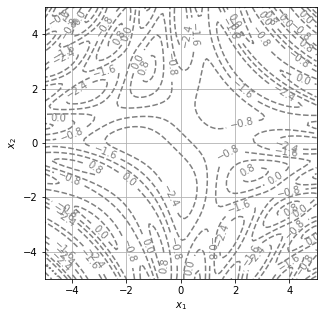

In [452]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [453]:
# La précision des courbes de niveau
# dépend de l'épaisseur du trait. La résolution de l'écran
# de notre ordinateur semble élevée, on prend donc epsilon 
# suffisamment petit, 0.001 nous semble suffisant. 

N = 100
eps = 0.001

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [454]:
def Newton(F, x0, y0, eps=eps, N=N):

    ''' 
    A chaque tour de boucle, on calcule des solutions approchées de plus 
    en plus précises de l'équation f(x,y) = 0. Pour cela on utilise l'inverse 
    de la matrice jacobienne de notre fonction et on applique la méthode de Newton 
    classique du cours de maths. On ajoute un message en cas de non convergence.
    '''
    j = J(F) 
    
    for i in range(N):
        (x, y) = (x0, y0) - np.dot(np.linalg.inv(j(x0, y0)), 
                                   F(x0, y0))
        
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y 
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")



**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

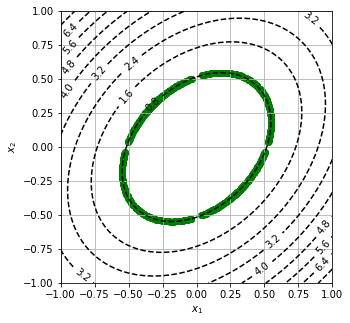

In [455]:
from itertools import product
L1 = []
L2, point_ref = [-1, 1], list(range(1, 15))
L3 = list(product(L2, L2)) 

# On fait le produit cartésien pour obtenir 
# une liste de points de références

point_ref = list(product(point_ref, point_ref))  

# On implémente une nouvelle fonction pour générer une liste 
# contenant les résultats de Newton pour différentes contraintes
# et différents points de référence. 

for a, b in L3:
    for i, j in point_ref:
        def h(x, y): 
            return np.array([f1(x, y) - .8, a*i*x - b*j*y]) 
        L1.append(Newton(h, a*0.8, b*0.8))
        
L1 = np.array(L1) # Pour la compatibilité avec display_contour_test

# On modifie la fonction display_contour en rajoutant un plt.scatter
# pour ajouter notre nuage de points issus de notre liste contenant
# les résultats de Newton pour différentes contraintes et 
# points de référence. 

def display_contour_test(f, x, y, levels, L):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="black", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)

    plt.scatter(L[:, 0], L[:, 1], c = 'g', marker = 'o')

    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

# On teste avec la fonction f1, on observe bien le tracé de toute
# notre courbe de niveau qui se superpose bien avec la courbe de référence 0.8

display_contour_test(f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10, 
    L=L1)

In [456]:
'''En faisant varier notre contrainte, on trace quasiment tous les différents points
de notre courbe de niveau '''

'En faisant varier notre contrainte, on trace quasiment tous les différents points\nde notre courbe de niveau '

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

In [457]:

def level_curve(f, x0, y0, delta=0.1, N=1000, eps=eps) : 
    
    rot = np.array([[0.0,1.0],[-1.0,0.0]]) #matrice de rotation de -pi/2
    grad_f = grad(f)
    valeurs = [[x0],[y0]]
    a, b = x0, y0     # point de départ
    c = f(x0,y0) #référence
    
    for i in range (1,N):
        vect_orthonorm = np.dot(rot,grad_f(a,b).T)  # vecteur orthogonal à grad(f) à droite en x0,y0        
        vect_orthonorm /= np.linalg.norm(vect_orthonorm,2) # On normalise      

        # On définit une nouvelle fonction de R2 dans R2 issue de f
        # ayant pour objectif de vérifier la contrainte 'à droite' d'être à une distance delta
        
        def f_contrainte(x,y):
            return np.array([f(x,y) - c, (x-a)*vect_orthonorm[0] + (y - b)*vect_orthonorm[1] - delta])
        a, b = Newton(f_contrainte, a, b, eps, 100)      
        valeurs[0].append(a)
        valeurs[1].append(b)
       
    return np.array([valeurs[0],valeurs[1]]) # On renvoie le tableau (2,N) des points de notre courbe de niveau.


### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

In [458]:
def level_curve_mieux(f, x0, y0, delta=0.1, N=1000, eps=eps) : 
    
    rot = np.array([[0.0,1.0],[-1.0,0.0]]) #matrice de rotation de -pi/2
    grad_f = grad(f)
    valeurs = [[x0],[y0]]
    a, b = x0, y0     # point de départ
    c = f(x0,y0) #référence
    
    for i in range (1,N):
        vect_orthonorm = np.dot(rot,grad_f(a,b).T)  # vecteur orthogonal à grad(f) à droite en x0,y0        
        vect_orthonorm /= np.linalg.norm(vect_orthonorm,2) # On normalise      

        # On définit une nouvelle fonction de R2 dans R2 issue de f
        # ayant pour objectif de vérifier la contrainte 'à droite' d'être à une distance delta
        
        def f_contrainte(x,y):
            return np.array([f(x,y) - c, (x-a)*vect_orthonorm[0] + (y - b)*vect_orthonorm[1] - delta])
        a, b = Newton(f_contrainte, a, b, eps, 100)      
        valeurs[0].append(a)
        valeurs[1].append(b)
        
        if ((a-x0)**2+(b-y0)**2)**0.5 < delta - eps: 
            return np.array([valeurs[0],valeurs[1]])
    return np.array([valeurs[0],valeurs[1]]) # On renvoie le tableau (2,N) des points de notre courbe de niveau.

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

In [459]:
# On définit deux fonctions permettant le tracé de nos courbes de niveau
# avec les différentes méthodes et fonctions proposées.


def display_contour_normal1(f,x0,y0, delta=0.1, N=100, eps = eps):
    X,Y = level_curve(f,x0,y0,delta, N, eps)
    display_contour(f, x=np.linspace(-1.0,1.0,100), y = np.linspace(-1.0,1.0,100), levels = 10)
    plt.plot(X,Y,'g:x')
    plt.title(f" Courbe avec level_curve classique pour {f}")
    plt.show()
    
def display_contour_mieux1(f,x0,y0, delta=0.1, N=100, eps = eps):
    X,Y = level_curve_mieux(f,x0,y0,delta, N, eps)
    display_contour(f, x=np.linspace(-1.0,1.0,100), y = np.linspace(-1.0,1.0,100), levels = 10)
    plt.plot(X,Y,'r:x')
    plt.title(f" Courbe avec level_curve_mieux pour {f}")
    plt.show()



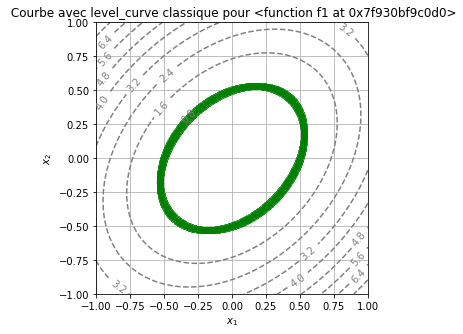

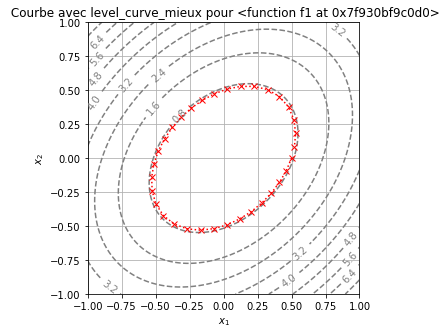

In [460]:

display_contour_normal(f1,0.5,0.0,0.1,1000,0.001)
display_contour_mieux(f1,0.5,0.0,0.1,1000,0.001)


In [464]:
def display_contour_normal2(f,x0,y0, delta=0.1, N=100, eps = eps):
    X,Y = level_curve(f,x0,y0,delta, N, eps)
    display_contour(f2, x=np.linspace(-1.0, 3.0, 100), y=np.linspace(-2.0, 2.0, 100), levels=[2**i for i in range(-3, 8)]) # levels: [0.125, 0.25, ..., 64, 128])
    plt.plot(X,Y,'g:x')
    plt.title(f" Courbe avec level_curve classique pour {f}")
    plt.show()
    
def display_contour_mieux2(f,x0,y0, delta=0.1, N=100, eps = eps):
    X,Y = level_curve_mieux(f,x0,y0,delta, N, eps)
    display_contour(f2, x=np.linspace(-1.0, 3.0, 100), y=np.linspace(-2.0, 2.0, 100), levels=[2**i for i in range(-3, 8)] )# levels: [0.125, 0.25, ..., 64, 128])
    plt.plot(X,Y,'r:x')
    plt.title(f" Courbe avec level_curve_mieux pour {f}")
    plt.show()



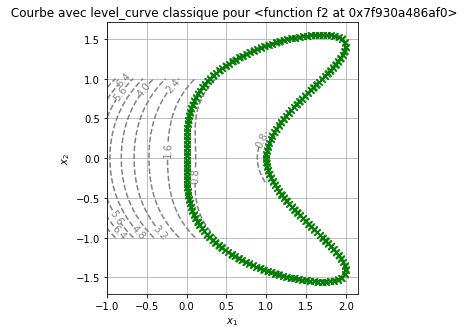

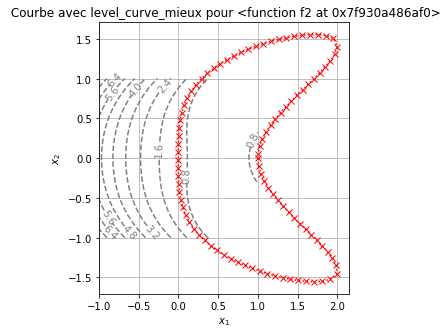

In [465]:
display_contour_normal(f2,1.0,0.0,0.1,1000,0.001)
display_contour_mieux(f2,1.0,0.0,0.1,1000,0.001)

In [466]:
def display_contour_normal3(f,x0,y0, delta=0.1, N=100, eps = eps):
    X,Y = level_curve(f,x0,y0,delta, N, eps)
    display_contour(f, x=np.linspace(-5.0,5.0,100), y = np.linspace(-5.0,5.0,100), levels = 10)
    plt.plot(X,Y,'g:x')
    plt.title(f" Courbe avec level_curve classique pour {f}")
    plt.show()
    
def display_contour_mieux3(f,x0,y0, delta=0.1, N=100, eps = eps):
    X,Y = level_curve_mieux(f,x0,y0,delta, N, eps)
    display_contour(f, x=np.linspace(-5.0,5.0,100), y = np.linspace(-5.0,5.0,100), levels = 10)
    plt.plot(X,Y,'r:x')
    plt.title(f" Courbe avec level_curve_mieux pour {f}")
    plt.show()

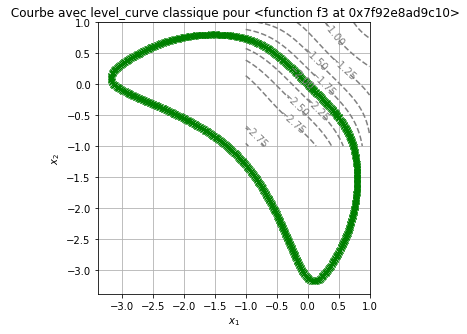

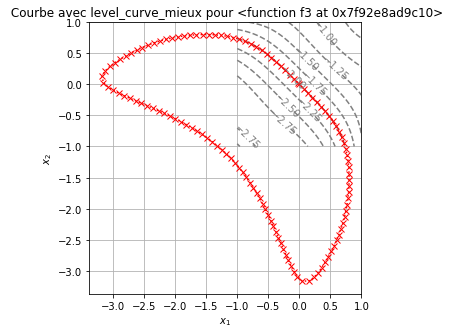

In [467]:
display_contour_normal(f3,0.0,0.0,0.1,1000,0.001)
display_contour_mieux(f3,0.0,0.0,0.1,1000,0.001)

In [468]:
# De par nos graphiques, on observe bien que pour la méthode améliorée, on trace moins de points, ce qui valide notre programme.


# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

In [469]:
def area_squares(f, c, h):
    a = 2
    n = np.linspace(-a, a ,int(2*a/h)+1)
    num = 0
    for i in n:
        for j in n:
            if f(i, j) <= c:
                num = num + 1
    return num*h**2

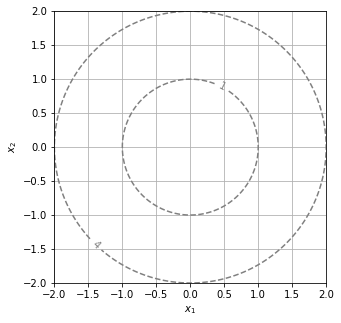

In [470]:
def disque_unite(x ,y):
    return(x * x + y * y)
display_contour(disque_unite, x=np.linspace(-2.0, 2.0, 100), y=np.linspace(-2.0, 2.0, 100), levels=[1, 4, 9, 16])

In [471]:
area_squares(disque_unite,1,0.001)

3.141543

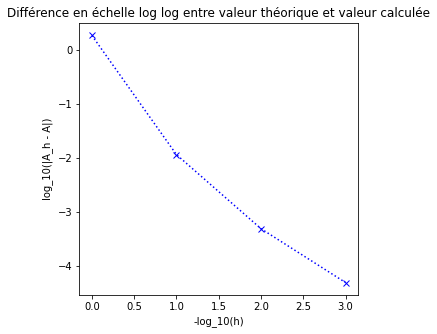

In [474]:
# On calcule l'aire pour différentes valeurs de précision. Puis on représente la différence entre l'aire théorique 
# et l'aire calculée en échelle log-log. 

X1 = []
X2 = []
for i in range (4):
    X1.append(i)
    X2.append(np.log10(np.abs(area_squares(disque_unite, 1, 10**(-i))-np.pi)))
plt.plot(X,Y,'b:x')
plt.title("Différence en échelle log log entre valeur théorique et valeur calculée")
plt.xlabel('-log_10(h)')
plt.ylabel('log_10(|A_h - A|)')
plt.show()

**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


In [475]:
# Pour minorer, on regarde sur chaque petits carrés si les 4 coins sont à l'intérieur de 
# courbe de niveau et on compte que ceux-ci. Pour majorer, on prend ceux où il y a au moins
# un sommet dans la courbe de niveau.
# Pour une majoration plus précise, on peut prendre 2 ou 3 sommets.

def area_squares_encadrement(f,c,h = 0.1):
    N=int((2*2)/h) #nombre d'itérations
    aire_min=0
    aire_max=0
    for i in range(N):
        for j in range(N):
    #tous les carrés autour sont sous la ligne de niveau
            if (f(-2+i*h,-2+j*h)) <= c and (f(-2+(i+1)*h,-2+j*h)) <= c and (f(-2+i*h,-2+(j+1)*h)) <= c and (f(-2+(i+1)*h,-2+(j+1)*h)) <= c:
                aire_min+=1
    #l'un des carrés autour est sous la ligne de niveau
            if (f(-2+i*h,-2+j*h)) <= c or (f(-2+(i+1)*h,-2+j*h)) <= c or (f(-2+i*h,-2+(j+1)*h)) <= c or (f(-2+(i+1)*h,-2+(j+1)*h)) <= c:
                aire_max+=1
    return (f"{aire_min*(h**2)} < aire < {aire_max*(h**2)}")

area_squares_encadrement(disque_unite, 1., 0.01)

'3.101 < aire < 3.1814'

In [476]:
# On observe bien un encadrement correct de notre aire

## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

In [477]:
# Dans cette fonction, on calcule l'aire algébrique des triangles en utilisant un produit vectoriel. On obtient 
# alors l'aire du parallélogramme qu'on divise donc par 2.

def area_triangles(courbe,L):
    
    '''courbe  est un tableau (2,n) avec tous les points de l'ensemble.'''
    aire=0
    nb_points = courbe.shape[1] 
    
    for k in range(1,nb_points):
        
        first_vect = np.array([courbe[0,k]-L[0],courbe[1,k]-L[1]])
        second_vect = np.array([courbe[0,k-1]-L[0],courbe[1,k-1]-L[1]])   
        aire += np.cross(first_vect,second_vect)/2 # Calcul de l'aire avec le produit vectoriel.
    aire += np.cross(np.array([courbe[0,0]-L[0],courbe[1,0]-L[1]]),[courbe[0,-1]-L[0],courbe[1,-1]-L[1]])/2
    
    # On ajoute l'aire formée par le triangle avec le premier et le dernier point. 
    return(aire)




In [478]:
# Le cas du cercle unité :

def norme(x,y):
    return (x**2+y**2)**(0.5)

def norme_contrainte(x,y):
    return np.array([norme(x,y)-1.,x-y])

x0,y0 = Newton(norme_contrainte,1.,1.)
courbe = level_curve_mieux(norme, x0,y0) 

L = np.array([0,0])
print(f"Le disque a une aire de {area_triangle(courbe,L)}")





Le disque a une aire de 3.1363704468569797


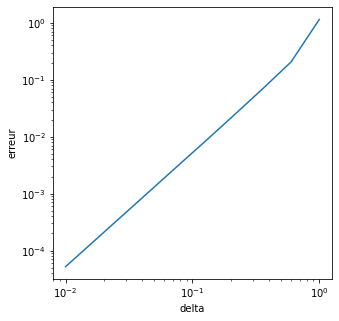

In [479]:
# On étudie la convergence lorsque delta tend vers 0. 

delta = np.logspace(-2,0,10) 
erreur = np.array([abs(area_triangle(level_curve_mieux(norme,x0,y0,i), np.array([0,0]))-np.pi) for i in delta ])
plt.loglog(delta,erreur) #tracé en échelle log-log
plt.xlabel('delta') 
plt.ylabel('erreur') 
plt.show()

# On a une pente de 100 ce qui correspond à une convergence en delta**2

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

In [480]:
print(f" En prenant le point = (1,1), on obtient une aire de {area_triangles(courbe, np.array([1,1]))}")

 En prenant le point = (1,1), on obtient une aire de 3.136370446856982


In [481]:
# On obtient une aire qui semble cohérente avec la théorie, notre méthode semble donc fonctionner, c'est
# dû au fait qu'on utilise un produit vectoriel qui fournit des aires signées.

**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [482]:
import time

debut = time.time()
aire = area_squares(f1,0.5,0.01)
fin = time.time()
print(f"Méthode des rectangles : le temps est {fin - debut} sec")
print(f"L'aire vaut {aire} avec un encadrement de {area_squares_encadrement(f1,0.5,0.01)}")

debut = time.time()
aire = area_triangles(level_curve_mieux(f1, 0.5, 0.0, 0.1, 100,0.01),np.array([1,1]))
fin = time.time()
print(f"Méthode des triangles : le temps est {fin - debut} sec ")
print(aire)



Méthode des rectangles : le temps est 0.9940371513366699 sec
L'aire vaut 0.5545 avec un encadrement de 0.5372 < aire < 0.5720000000000001
Méthode des triangles : le temps est 0.06993889808654785 sec 
0.8278603229504923


In [483]:
debut = time.time()
aire = area_squares(f2,1.0,0.01)
fin = time.time()
print(f"Méthode des rectangles : le temps est {fin - debut} sec")
print(f"L'aire vaut {aire} avec un encadrement de {area_squares_encadrement(f2,1.,0.01)}")

debut = time.time()
aire = area_triangles(level_curve_mieux(f2, 1.0, 0.0, 0.1, 100,0.01),np.array([1,1]))
fin = time.time()
print(f"Méthode des triangles : le temps est {fin - debut} sec ")
print(aire)

Méthode des rectangles : le temps est 0.16851520538330078 sec
L'aire vaut 3.6711 avec un encadrement de 3.6102000000000003 < aire < 3.7322
Méthode des triangles : le temps est 0.1593639850616455 sec 
3.6668483190531846


In [484]:
debut = time.time()
aire = area_squares(f3,-2.0,0.01)
fin = time.time()
print(f"Méthode des rectangles : le temps est {fin - debut} sec")
print(f"L'aire vaut {aire} avec un encadrement de {area_squares_encadrement(f3,-2.,0.01)}")

debut = time.time()
aire = area_triangles(level_curve_mieux(f3, 0.0, 0.0, 0.1, 1000,0.01),np.array([0,0]))
fin = time.time()
print(f"Méthode des triangles : le temps est {fin - debut} sec ")
print(aire)

Méthode des rectangles : le temps est 0.6109650135040283 sec
L'aire vaut 5.1563 avec un encadrement de 5.1002 < aire < 5.1862
Méthode des triangles : le temps est 0.2824058532714844 sec 
7.052817080469626


In [ ]:
''' Comparaison des deux méthodes
La méthode des triangles semble converger plus vite que la méthode des carrés 
et elle est aussi plus précise. (On le remarque pour le cercle unité
mais pour les autres fonctions, notre area_squares semble disfonctionnelle
ce qui empêche une comparaison correcte.) 
Pour les inconvénients : la méthode des triangles ne permet pas de réaliser un encadrement de l'aire.
'''